# Tensorflow for Deep Learning

Learning Objectives: <br> By the end of this assignment, you should be familiarized with implementing two CNN layers: convolution and pooling. You should be comfortable with researching Tensorflow documentation with the goal of discovering various code functionalities.

In [1]:
# If you're using Google colab, uncomment and run the magic command below prior to importing
# %tensorflow_version 2.x

In [2]:
import tensorflow as tf
tf.__version__

'2.3.1'

In [3]:
import matplotlib.pyplot as plt
import numpy as np

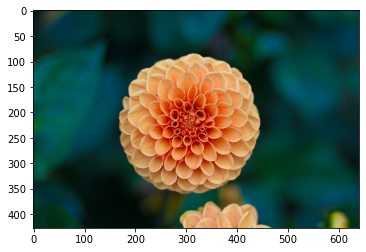

In [4]:
# Run cell -- you should see an image of a flower
from sklearn.datasets import load_sample_image

flower = load_sample_image('flower.jpg')
    
_ = plt.imshow(flower)

In [5]:
# Run cell -- dataset of one 100 x 100 x 3 RGB image
dataset = np.array([flower], dtype = np.float32)

count, height, width, channels = dataset.shape
count, height, width, channels

(1, 427, 640, 3)

In [16]:
# *** TO DO ***
# 1) Convert dataset to tensor object
data = pass

In [ ]:
# *** TO DO ***
# 2) Create a vertical line filter that will be applied using Tensorflow's tf.nn.conv2d function
filter_height, filter_width = 10, 10
channels_input, channels_output = 3, 1

filters = np.zeros(shape = (pass, pass, pass, pass), dtype = np.float32)
filters[:, 5:7, :, 0] = 1

In [ ]:
# *** TO DO ***
# 3) create a convolution layer using tf.nn.conv2d and pass in the following arguments: image we are processing, filters, and strides
convolution = ...(..., ..., strides = [1, 10, 10, 1], padding = "SAME")
output = convolution.numpy()

In [ ]:
# Run cell 
plt.imshow(output[0, :, : 0], cmap = "gray")
plt.show()

In [ ]:
# *** To DO *** 
# 4) Using tf.keras.layers.Conv2D, create a layer with three filters, a 5x5 
# visual receptor, and stride of 2
convolution = ......(filters = pass, kernel_size = pass, strides = pass, padding = "SAME")
output = convolution(X).numpy()

In [ ]:
# *** TO DO ***
# 5) Plot the first feature map: 
plt.imshow(output[pass, :, :, pass])
plt.show()

In [ ]:
# *** To DO ***
# 6) Plot the second feature map: 
plt.imshow(output[pass, :, :, pass])
plt.show()

In [ ]:
# *** TO DO *** 
# 7) Plot the third feature map: 
plt.imshow(ouutput[pass, :, : pass])
plt.show()

In [ ]:
# *** TO DO *** 
# 8) Pass the flower image into the tf.nn.max_pool function below
size = [1, 2, 2, 1]
maxpool = tf.nn.maxpool(pass, ksize = size, strides = size, padding = "VALID")
output = maxpool.numpy()
plt.imshow(output[0].astype(np.uint8))
plt.show()

## Final Exercise
Let's build a model that classifies images into 10 different categories. 
Requirements: 3 convolution layers, each followed by a maxpooling layer; 2 dense layers at the end; adam optimization

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers. ...(16, 3, padding='same', activation= pass,
                           input_shape=(100, 100, 3)),
    tf.keras.layers. ...,
    tf.keras.layers. ... (32, 3, padding='same', activation= pass),
    tf.keras.layers. ...,
    tf.keras.layers. ... (64, 3, padding='same', activation= pass),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers. ... (256, activation= pass),
    tf.keras.layers. ... (128, activation= pass)
])

model.compile(optimizer = pass
              loss = pass,
              metrics = ['accuracy'])

model.summary()